# Investigating well position effect: qualitative analysis with UMAPs
**Author:** Jessica Ewald <br>

Figure 3 in the [LUAD paper](https://www.molbiolcell.org/doi/10.1091/mbc.E21-11-0538) show clear differences in REF vs. VAR cells using UMAPs. This represents another way of assessing differences between perturbations. Here, we examine the top most separable well pairs for each comparison type (REF-REF, VAR-VAR, and REF-VAR) based on the classifier results from Scenario 4, and make UMAPs at the single-cell level. We want to know if the pairs with true morphology differences (REF-VAR) appear more separable than the ones without (REF-REF, VAR-VAR).

In [1]:
import pathlib
import polars as pl
import pandas as pd
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
# define file paths
data_path = "/dgx1nas1/storage/data/jess/varchamp/sc_data/processed_profiles/Rep_Ctrls/annotated_normalized_featselected.parquet"

# Scan & filter parquet
sc_profiles = pl.scan_parquet(data_path)


In [3]:

# Get all feat variable names  
feat_col = [i for i in sc_profiles.columns if "Metadata_" not in i]
meta_col = [i for i in sc_profiles.columns if "Metadata_" in i]

# Include only GFP features for protein channel 
feat_cols_protein = [i
                        for i in feat_col
                        if ("GFP" in i)
                        and ("DNA" not in i)
                        and ("AGP" not in i)
                        and ("Mito" not in i)
                        and ("Brightfield" not in i)]

# Select non-protein channel features, where GFP and Brightfield does not exist in feat_cols
feat_cols_non_protein = [i 
                            for i in feat_col 
                            if ("GFP" not in i)
                            and ("Brightfield" not in i)]

# Select only brightfield features
feat_cols_brightfield = [i 
                            for i in feat_col
                            if ("Brightfield" in i)
                            and ("DNA" not in i)
                            and ("AGP" not in i)
                            and ("Mito" not in i)
                            and ("GFP" not in i)]

In [4]:
# filter to keep only cells of interest
sc_profiles = sc_profiles.filter((pl.col("Metadata_SYMBOL") == "ALK") &
                                    (pl.col("Metadata_Batch") == 4)).collect()

df_rr = sc_profiles.filter(pl.col("Metadata_Well").is_in(["A19", "E02"]))
df_vv = sc_profiles.filter(pl.col("Metadata_Well").is_in(["C01", "F13"]))
df_rv = sc_profiles.filter(pl.col("Metadata_Well").is_in(["A20", "C01"]))

In [26]:
# Compute UMAP
reducer = umap.UMAP(n_components=2)

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr.select(feat_col)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv.select(feat_col)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv.select(feat_col)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

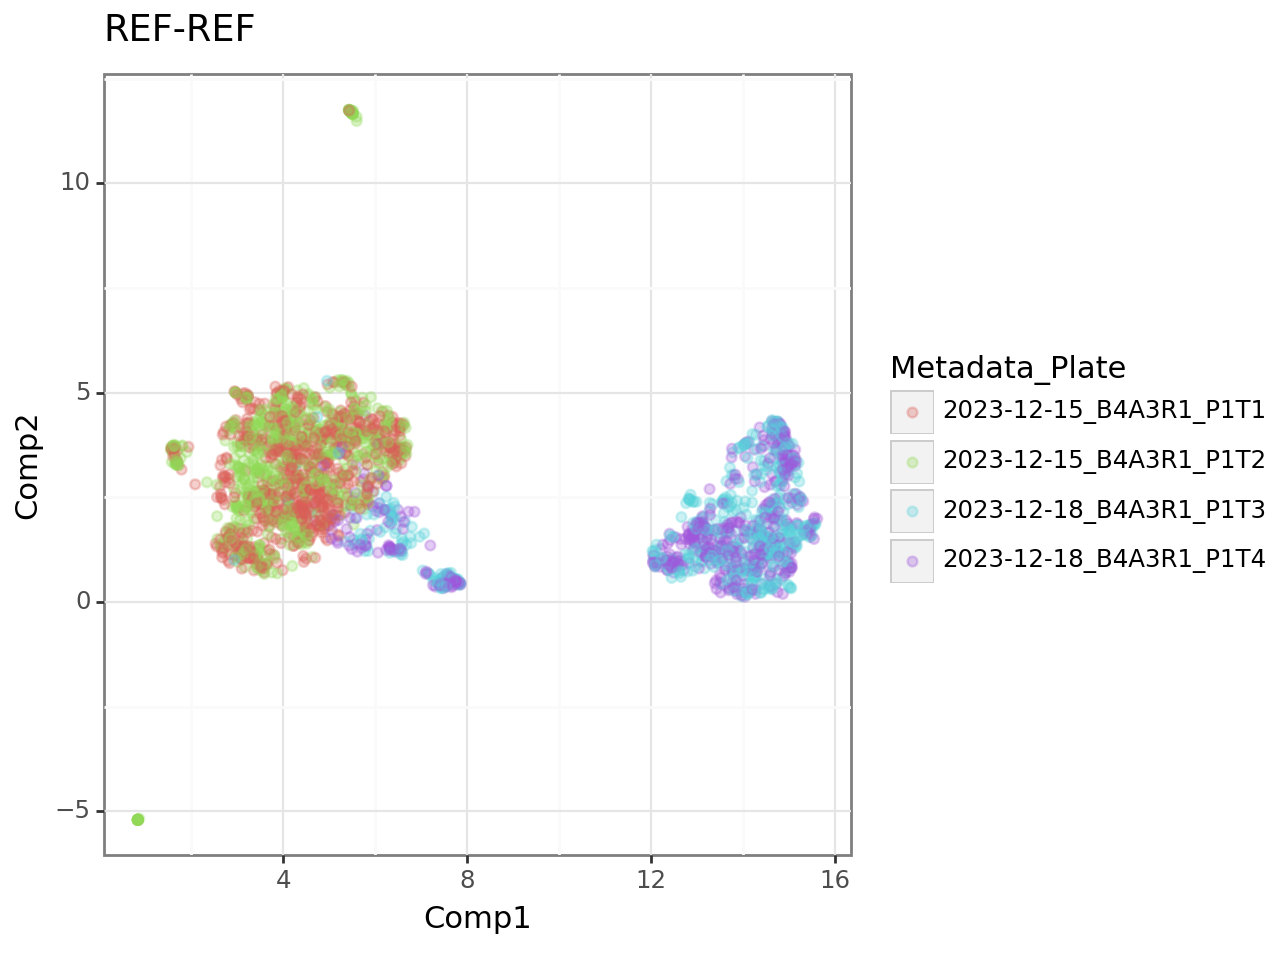

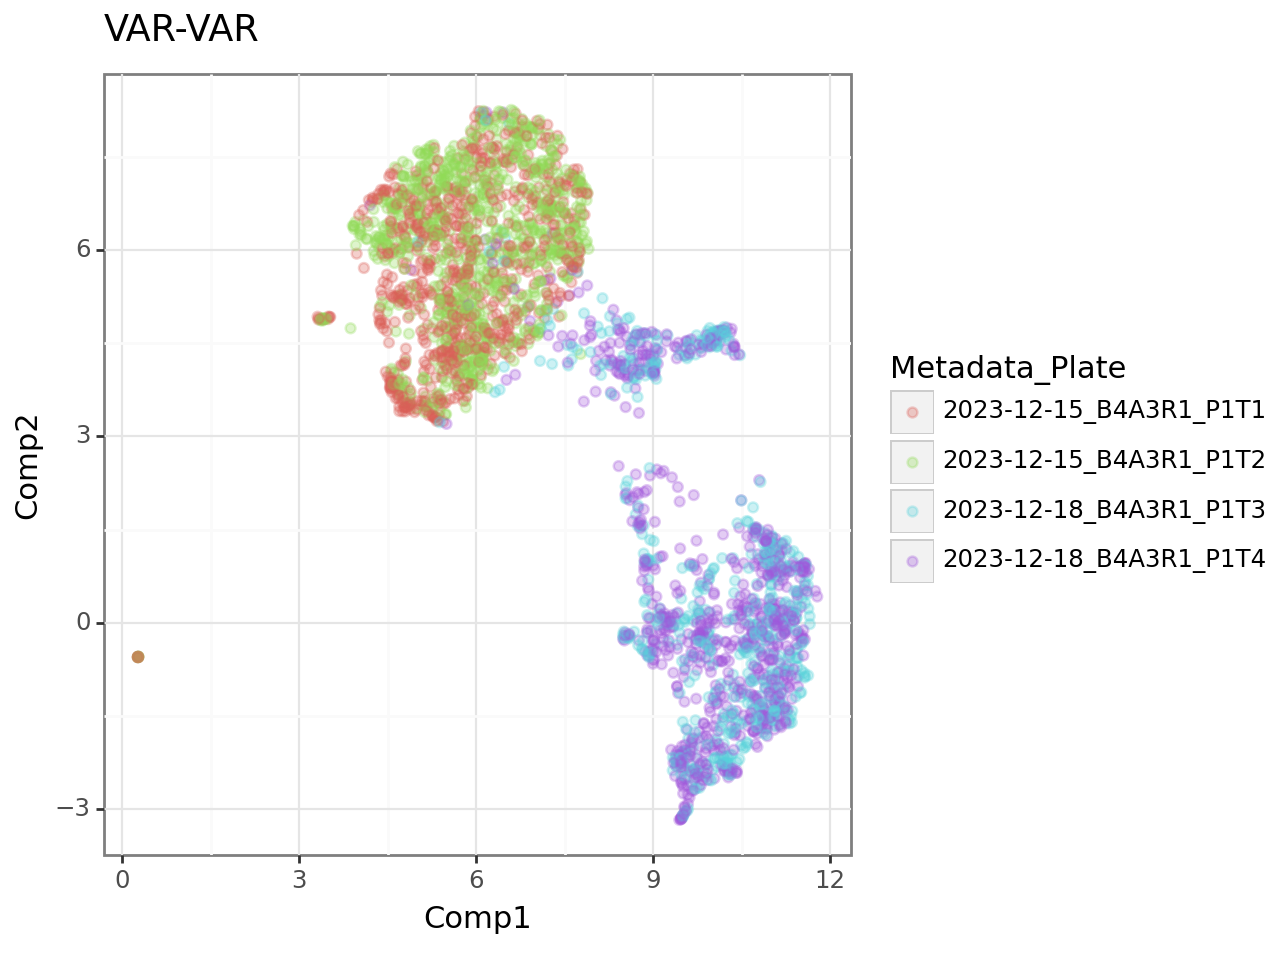

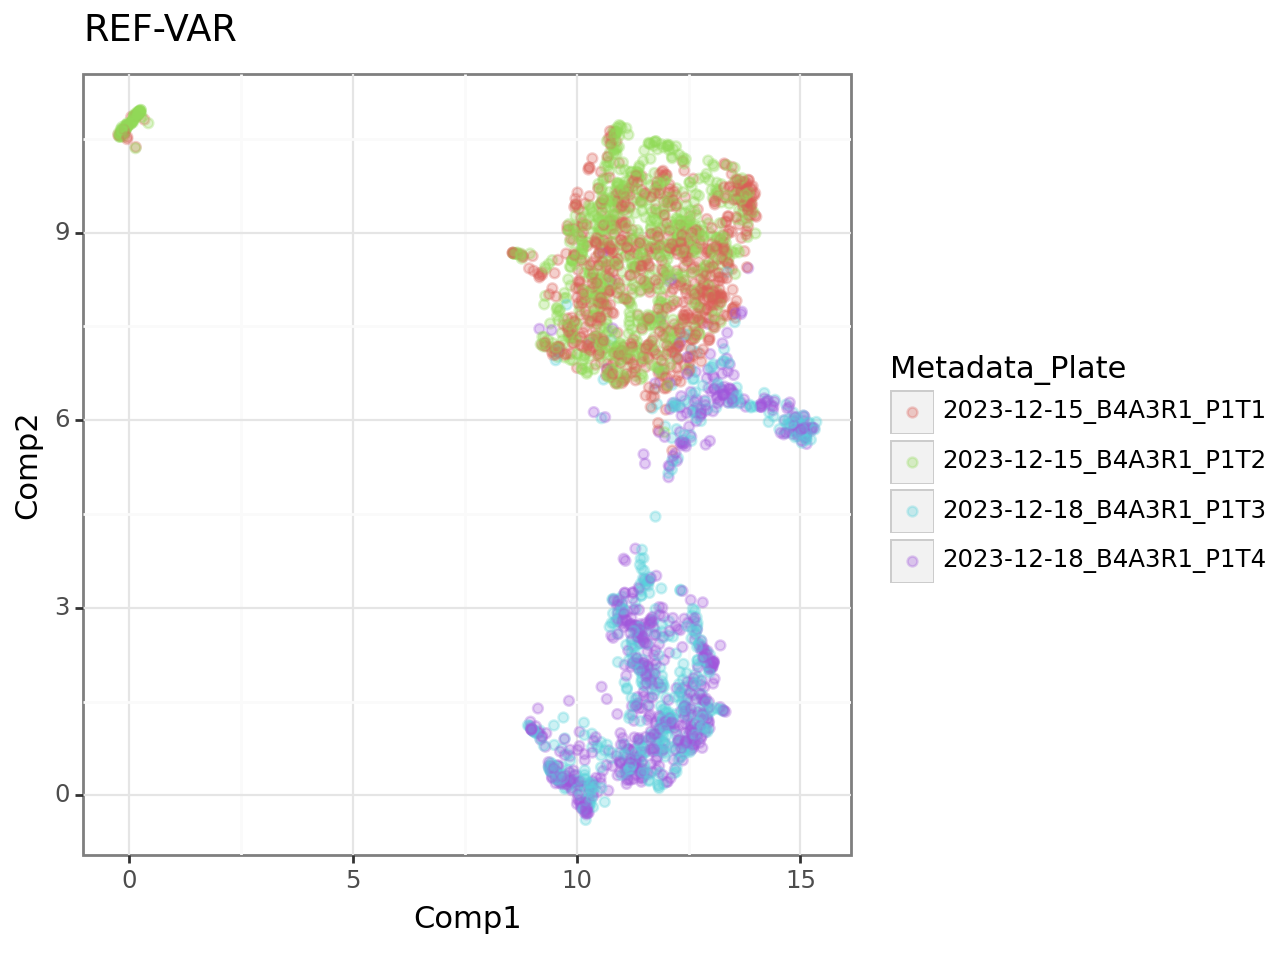

In [27]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_gradient

plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

Separation is by plate, or more specifically, by the two dates on which images were acquired. Next, try filtering to only include data from only one plate to see if this reveals relative morphological differences. 

NOTE: I also tried with all plates from batch 6; here, all plates were imaged on the same day and so there isn't the same separation by plate. However, the cells are still not grouped by well position. 

In [38]:
# Filter to look at only cells from one plate
df_rr_p1 = df_rr.filter(pl.col("Metadata_Plate").is_in(["2023-12-15_B4A3R1_P1T1"]))
df_vv_p1 = df_vv.filter(pl.col("Metadata_Plate").is_in(["2023-12-15_B4A3R1_P1T1"]))
df_rv_p1 = df_rv.filter(pl.col("Metadata_Plate").is_in(["2023-12-15_B4A3R1_P1T1"]))

In [39]:
# Re-compute UMAP embeddings
reducer = umap.UMAP(n_components=2)

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr_p1.select(feat_col)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv_p1.select(feat_col)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv_p1.select(feat_col)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

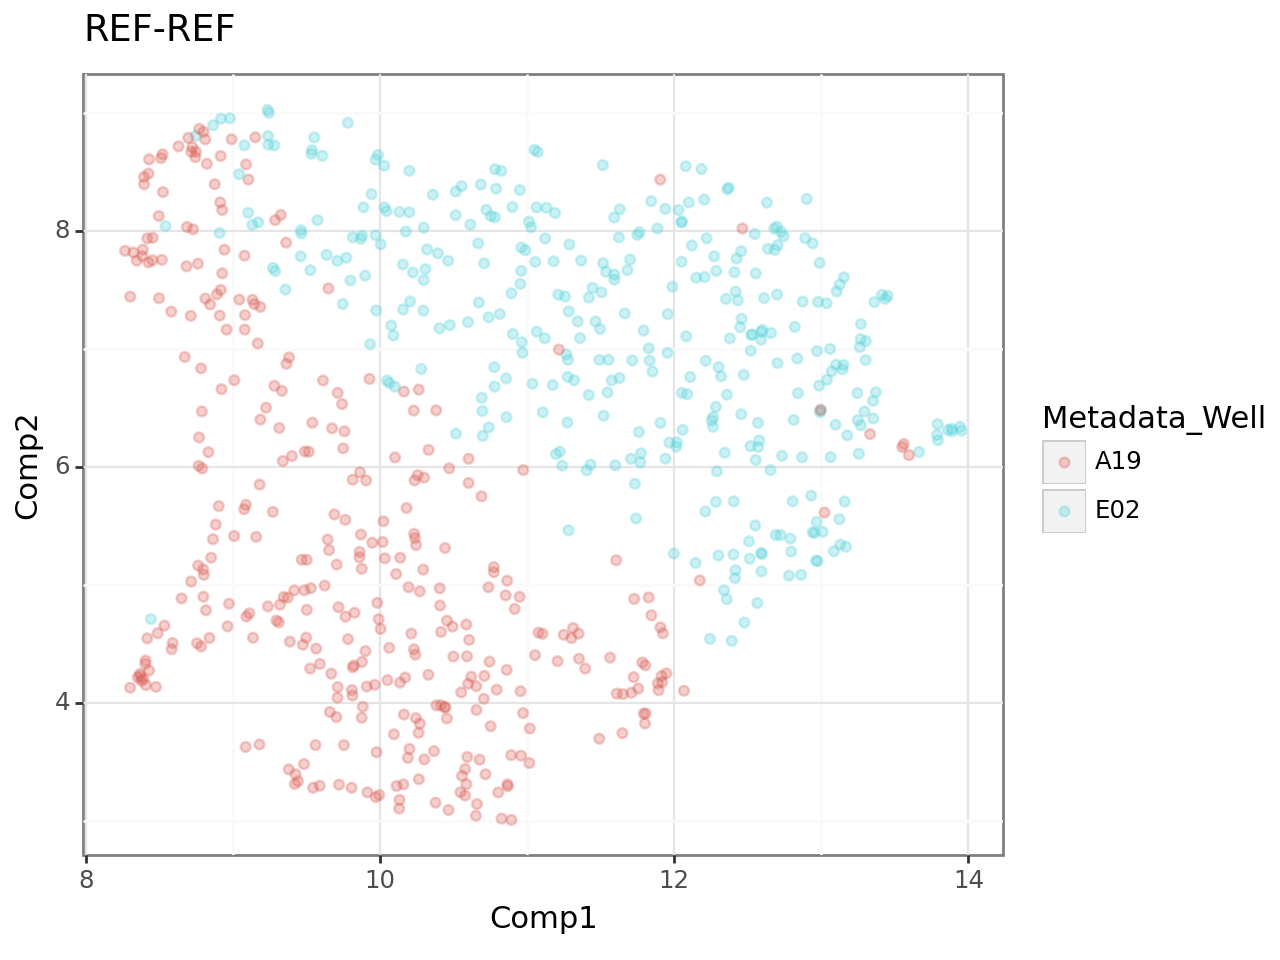

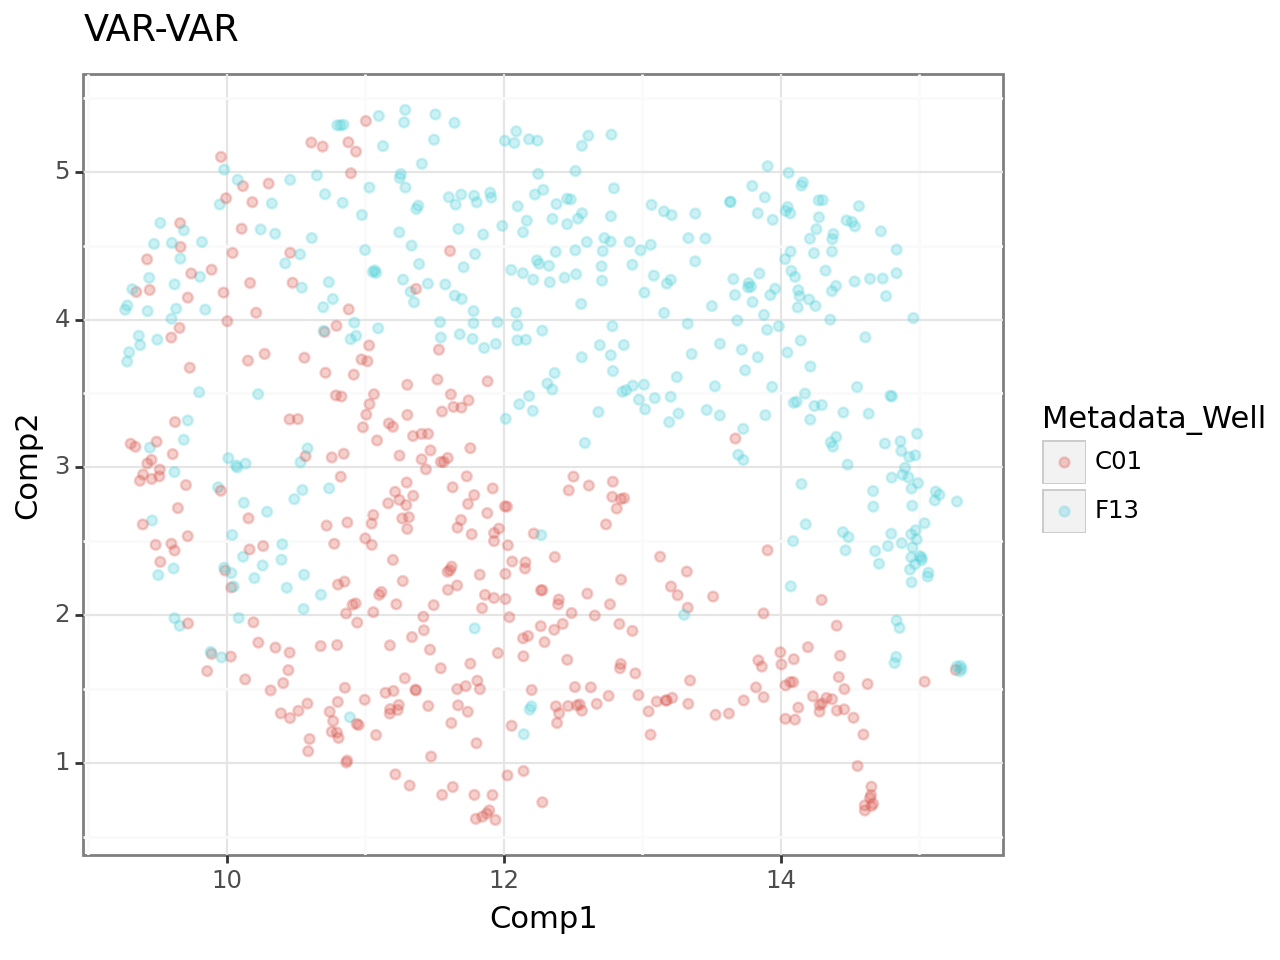

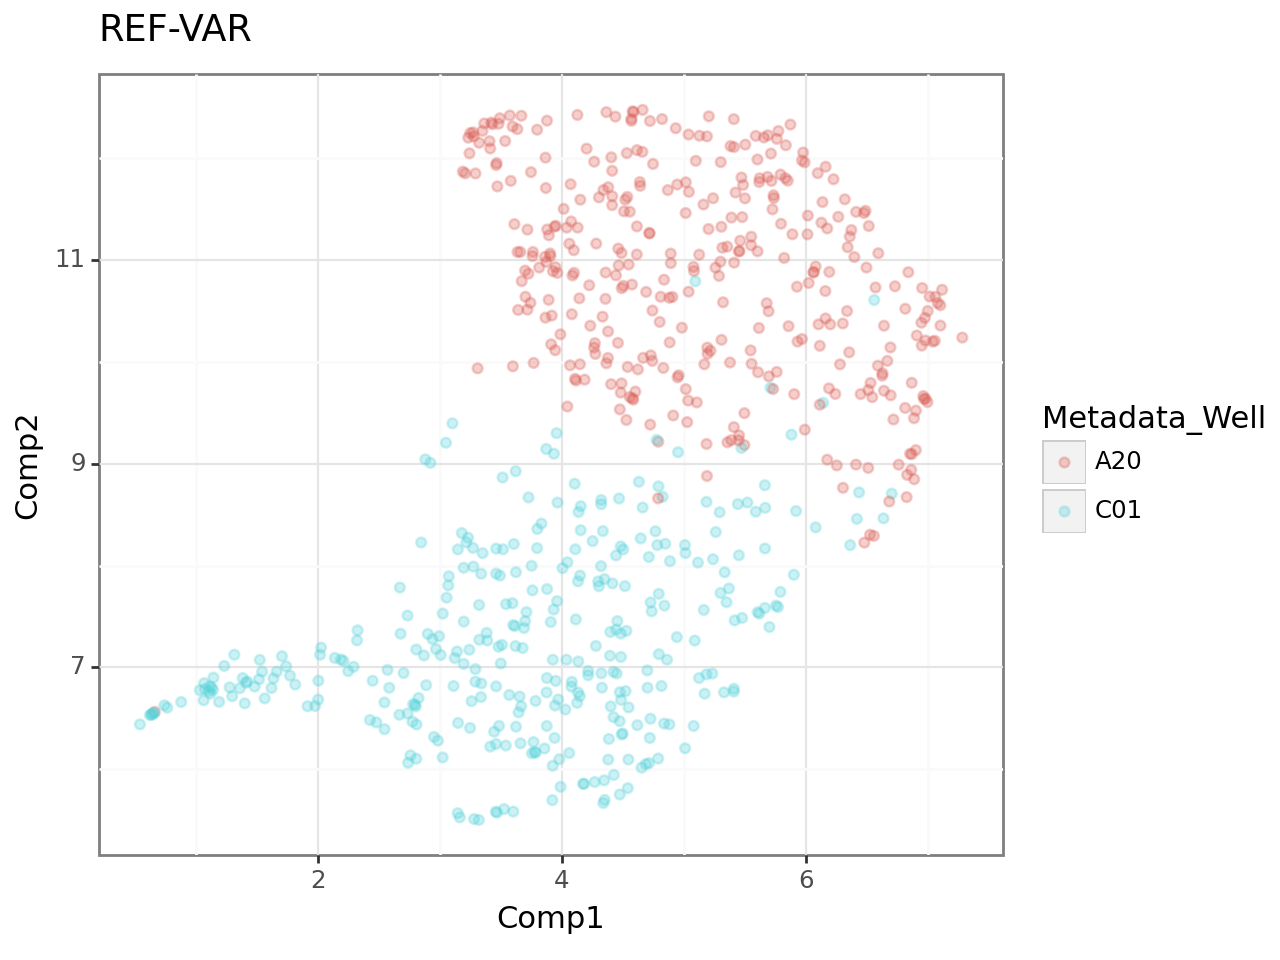

In [40]:
# Re-plot UMAP embeddings
plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

Now we see greater separation according to perturbation, although there still is separation by well position in the REF-REF. The previous analysis where I trained classifiers using different feature sets showed that some feature sets were more predictive of well position than others. Next, try performing UMAP computation & visualization separately for each feature set.

## Protein features

In [41]:
# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr_p1.select(feat_cols_protein)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv_p1.select(feat_cols_protein)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv_p1.select(feat_cols_protein)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

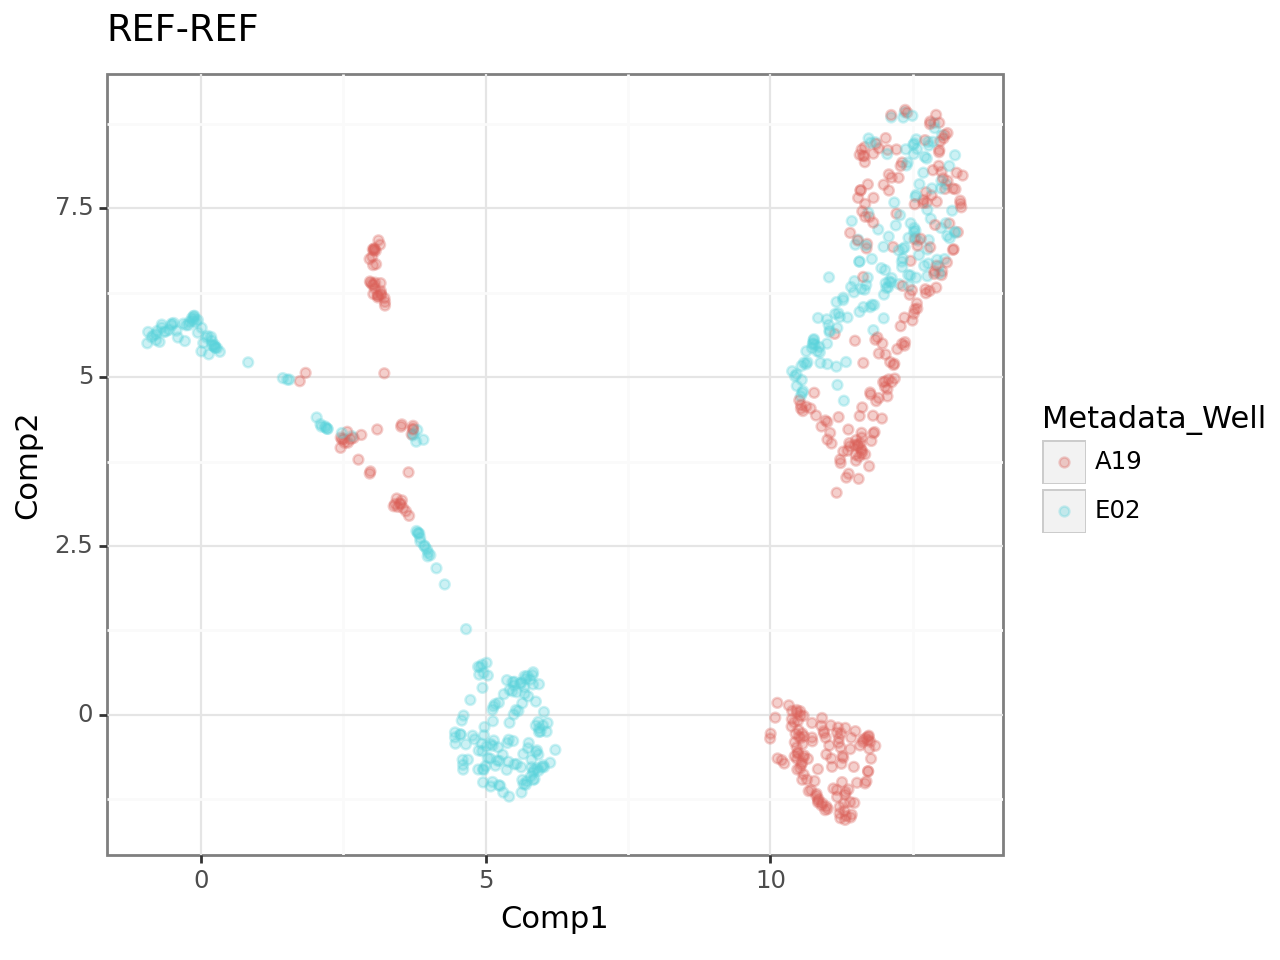

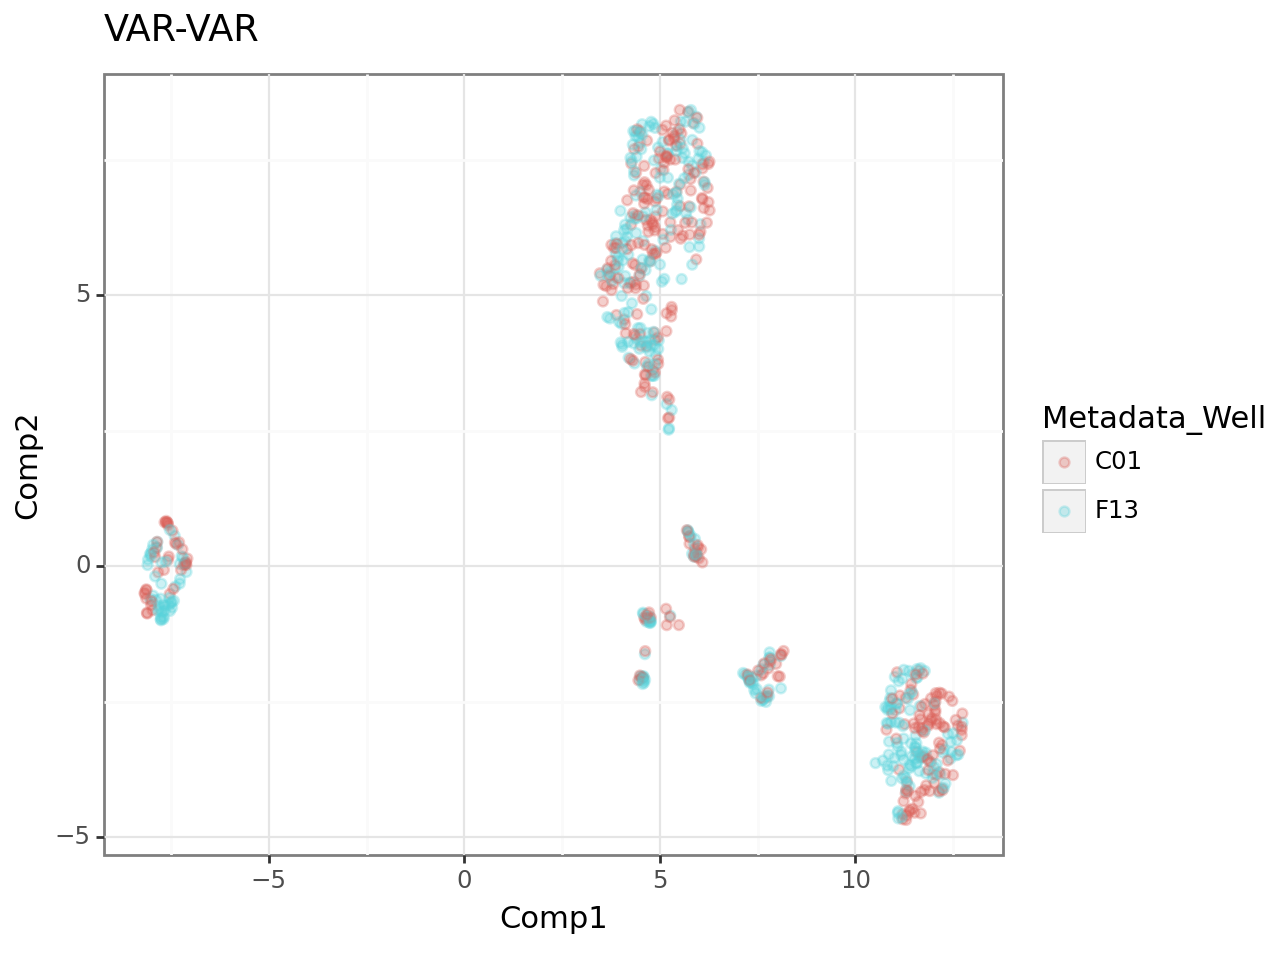

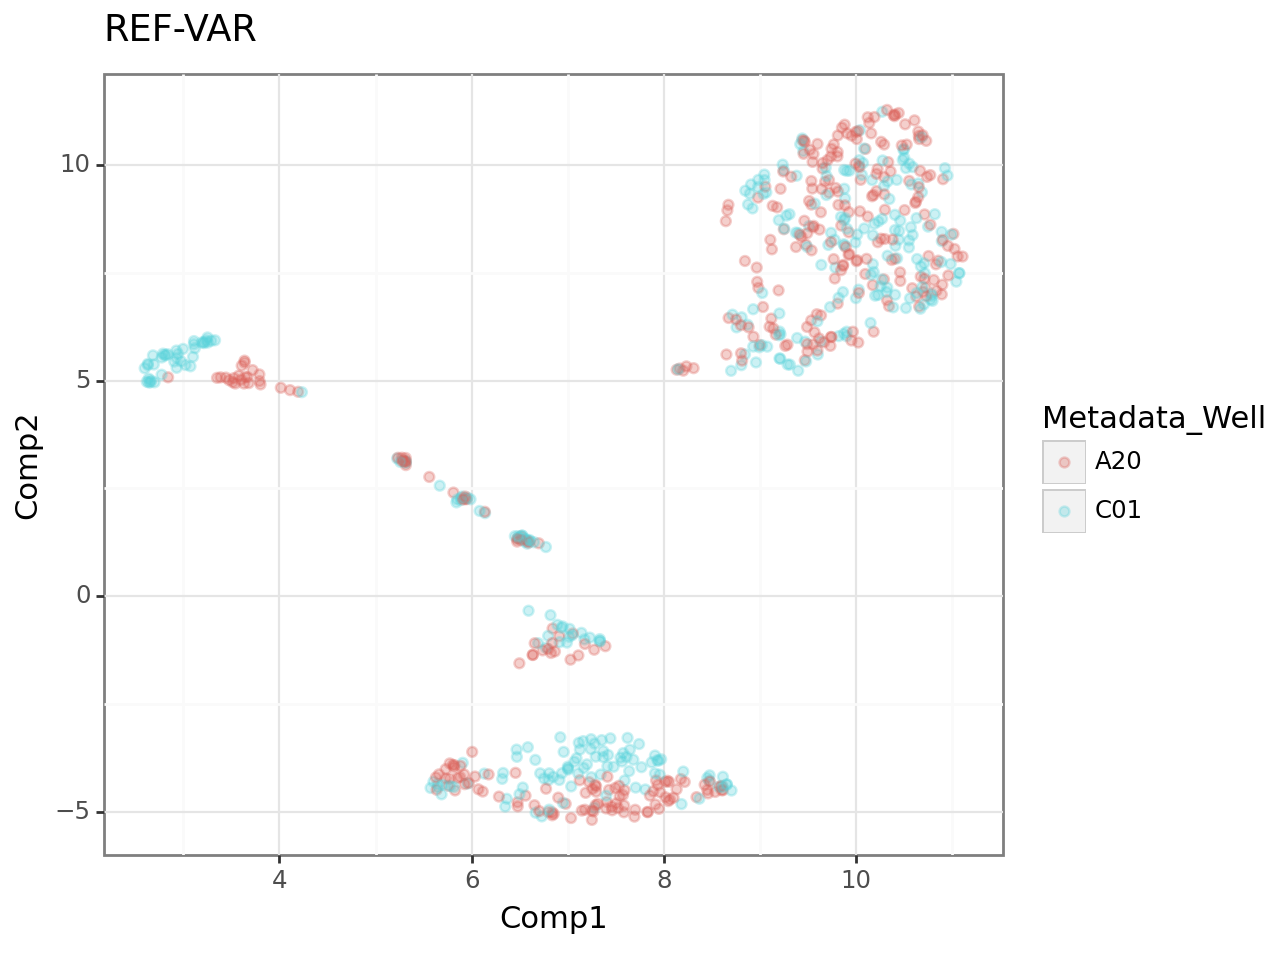

In [42]:
plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

## Non-protein fluorescent features

In [43]:
# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr_p1.select(feat_cols_non_protein)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv_p1.select(feat_cols_non_protein)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv_p1.select(feat_cols_non_protein)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

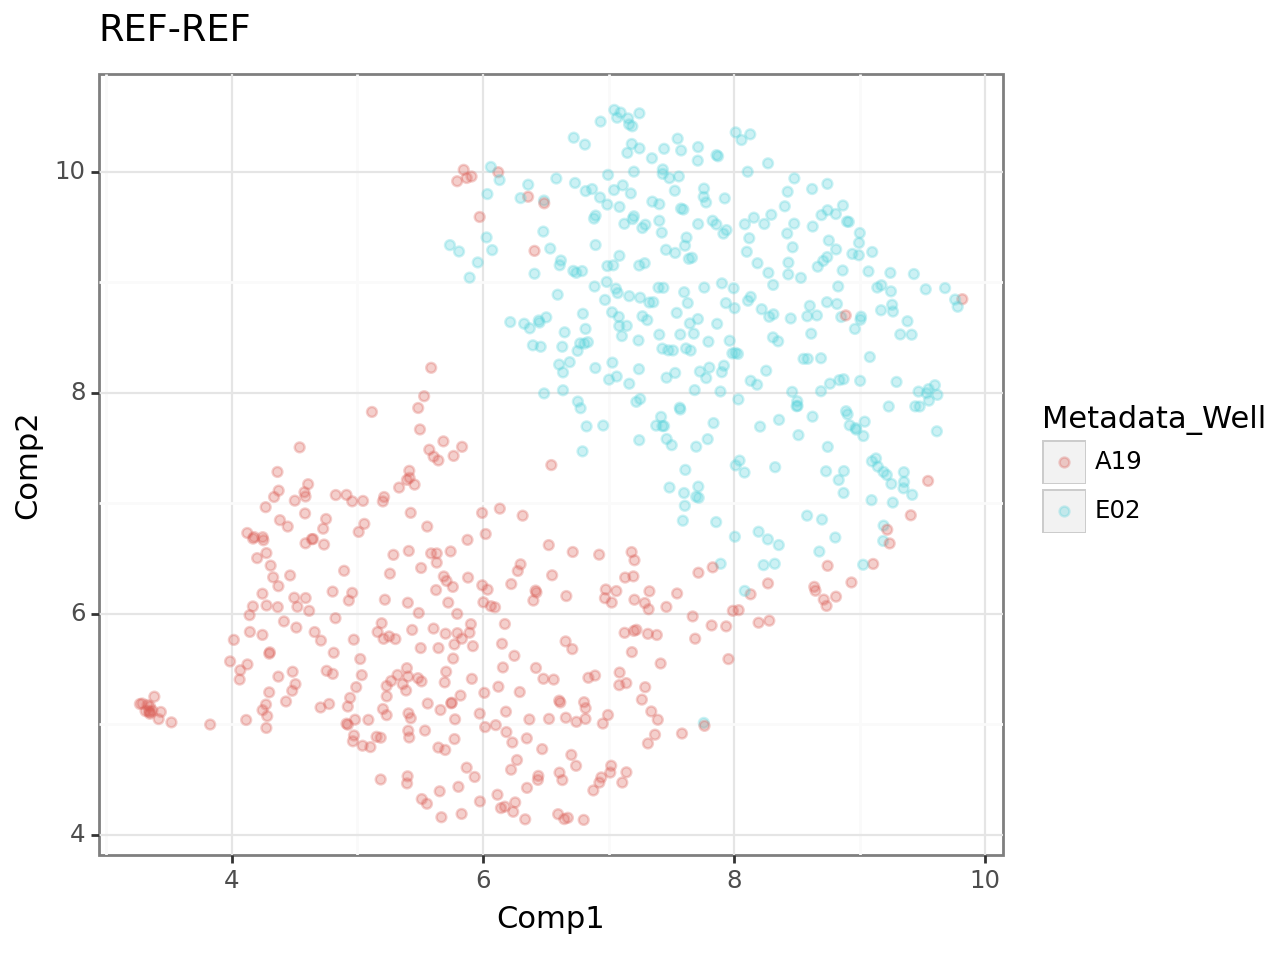

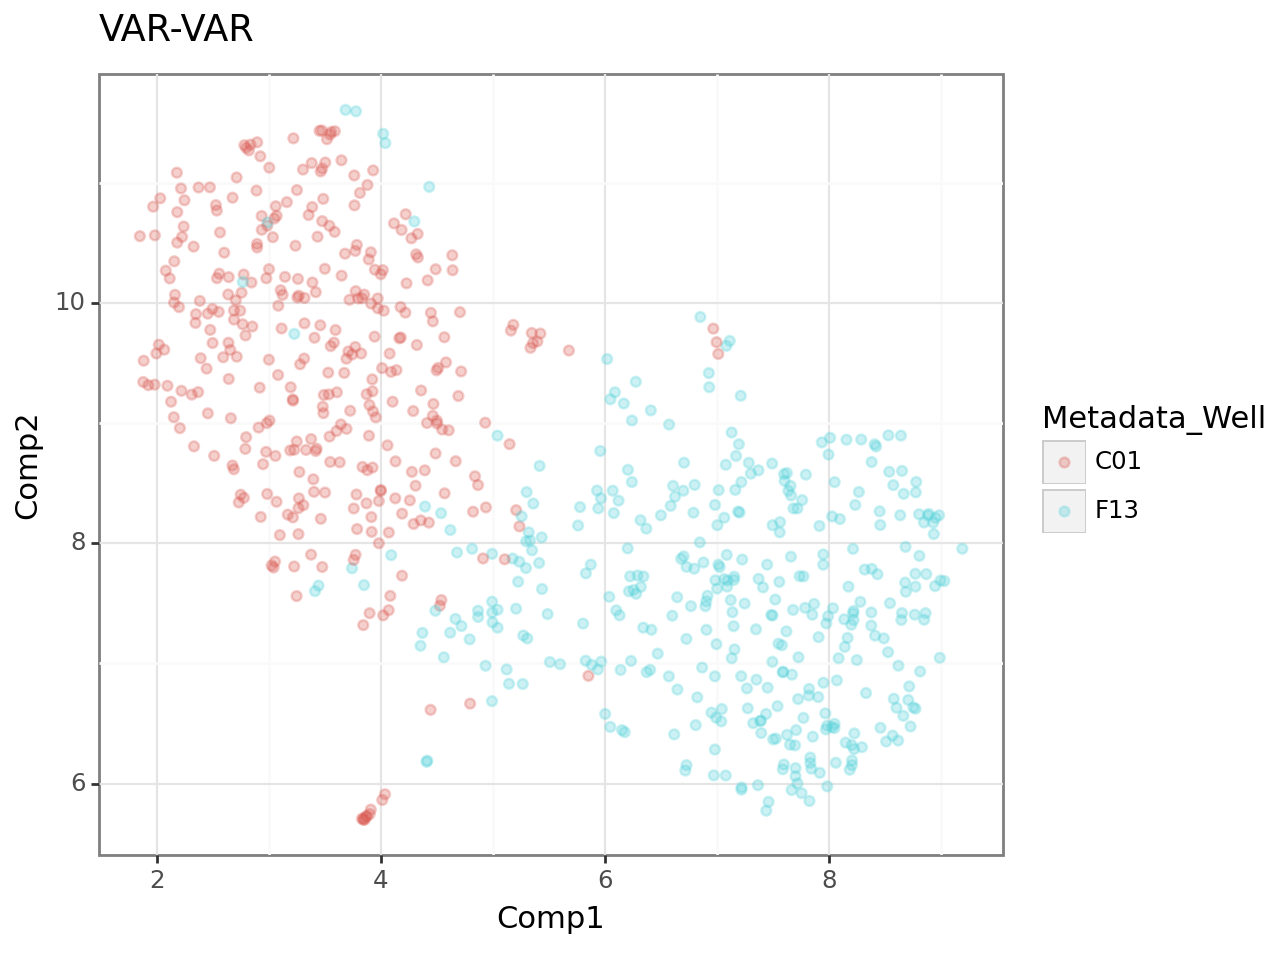

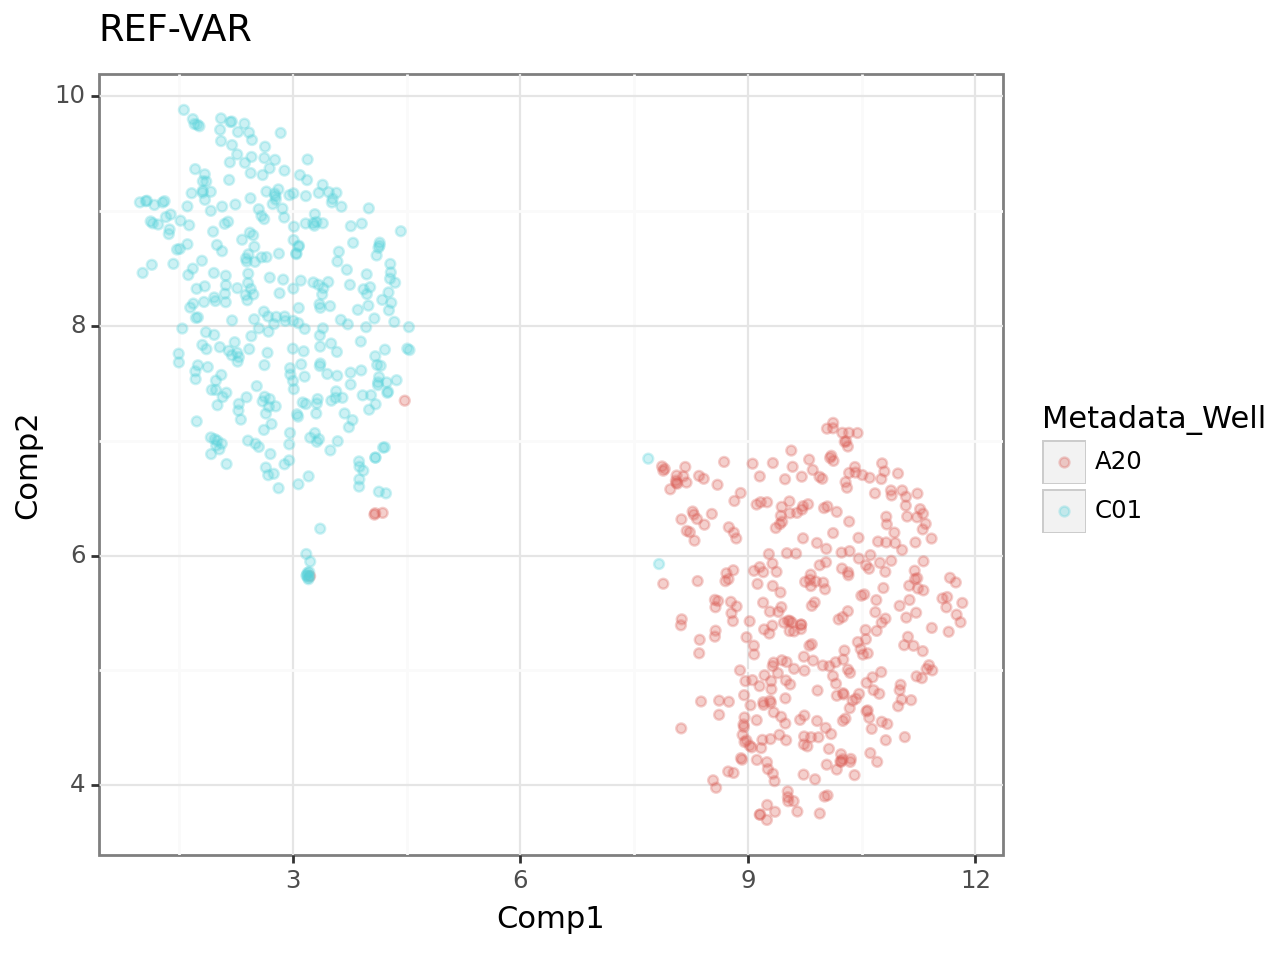

In [44]:
plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

## Brightfield features

In [45]:
# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr_p1.select(feat_cols_brightfield)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv_p1.select(feat_cols_brightfield)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv_p1.select(feat_cols_brightfield)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

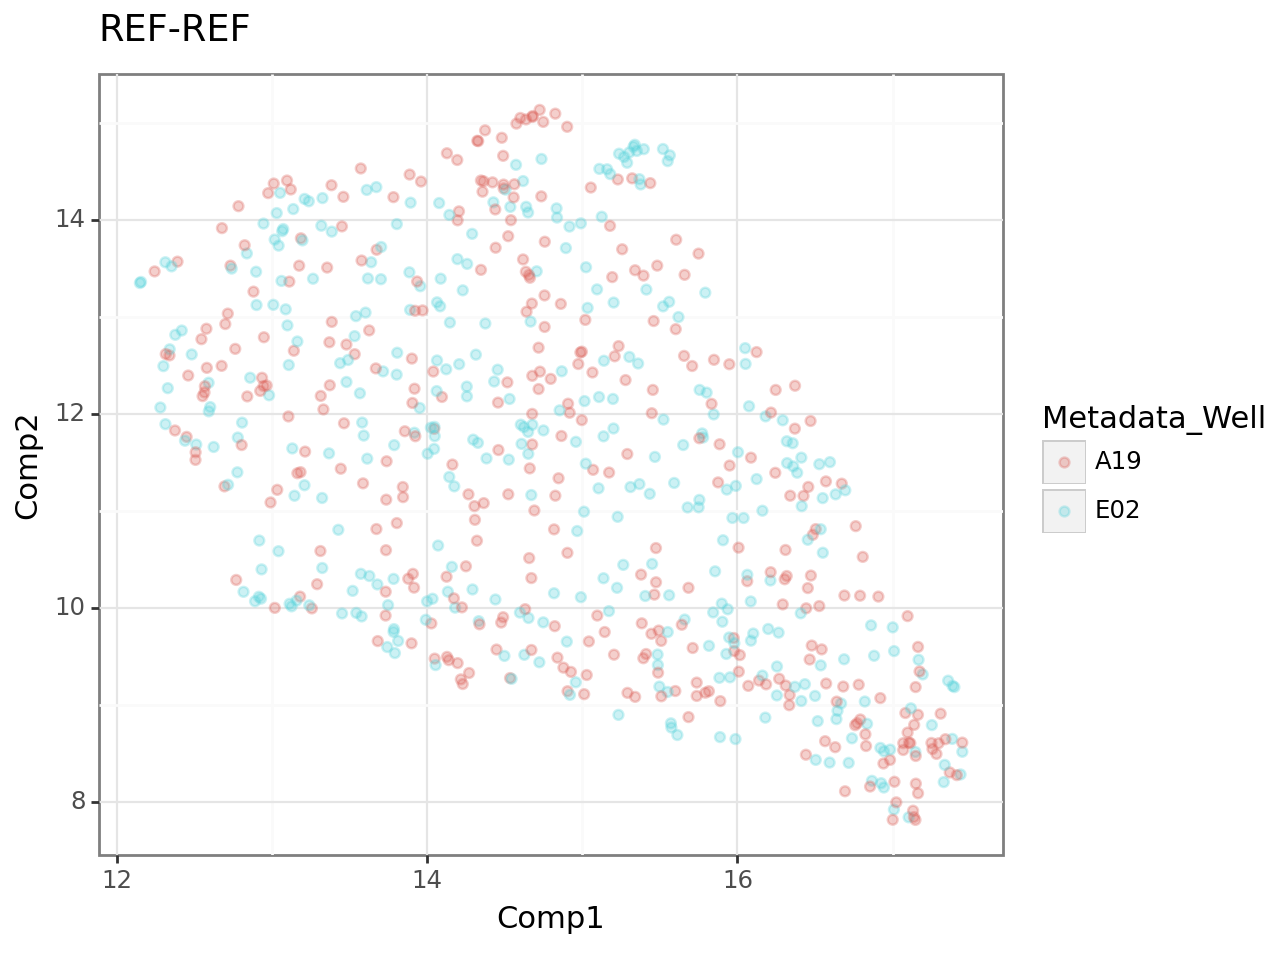

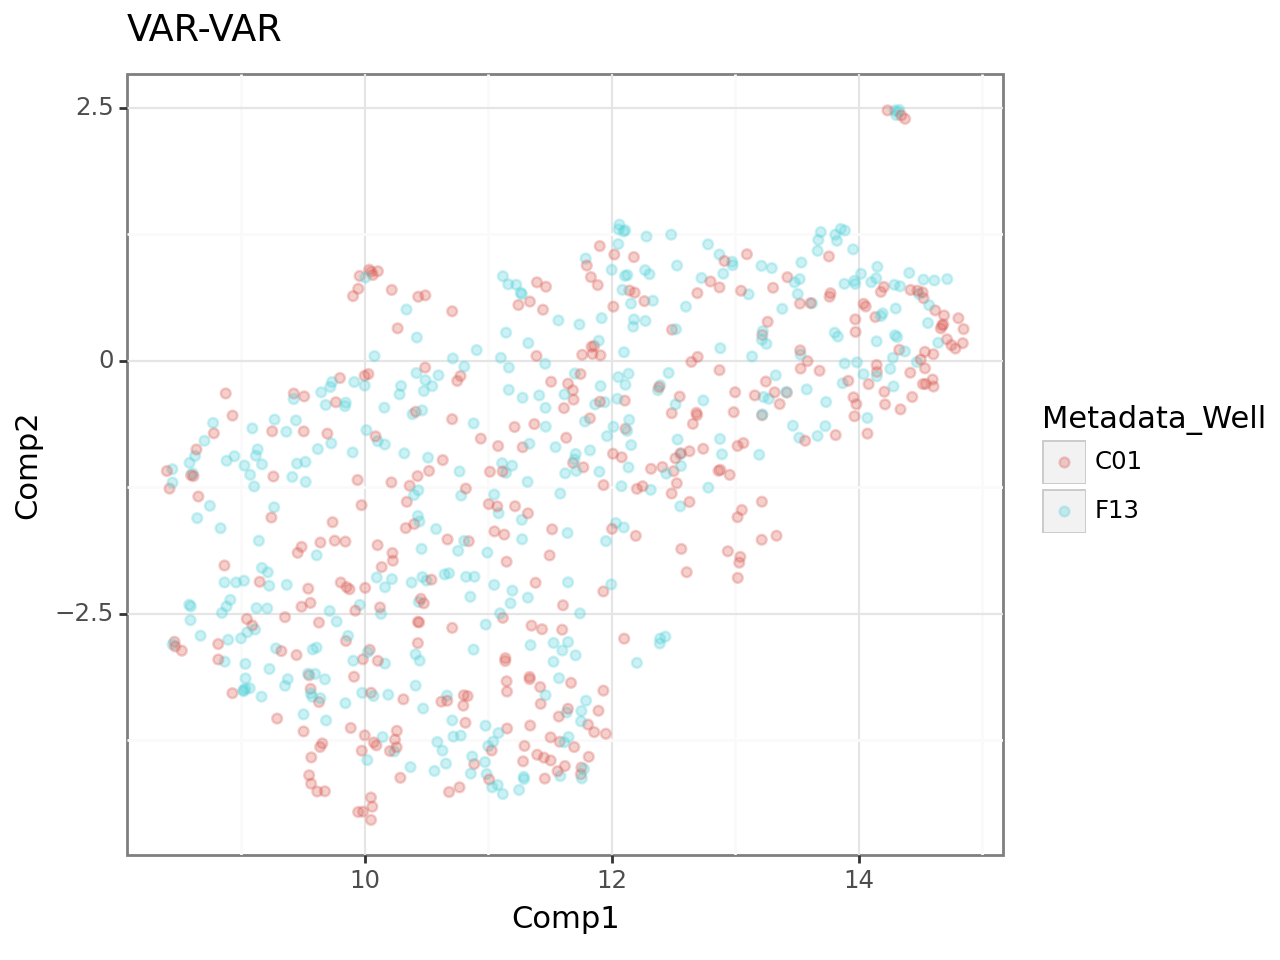

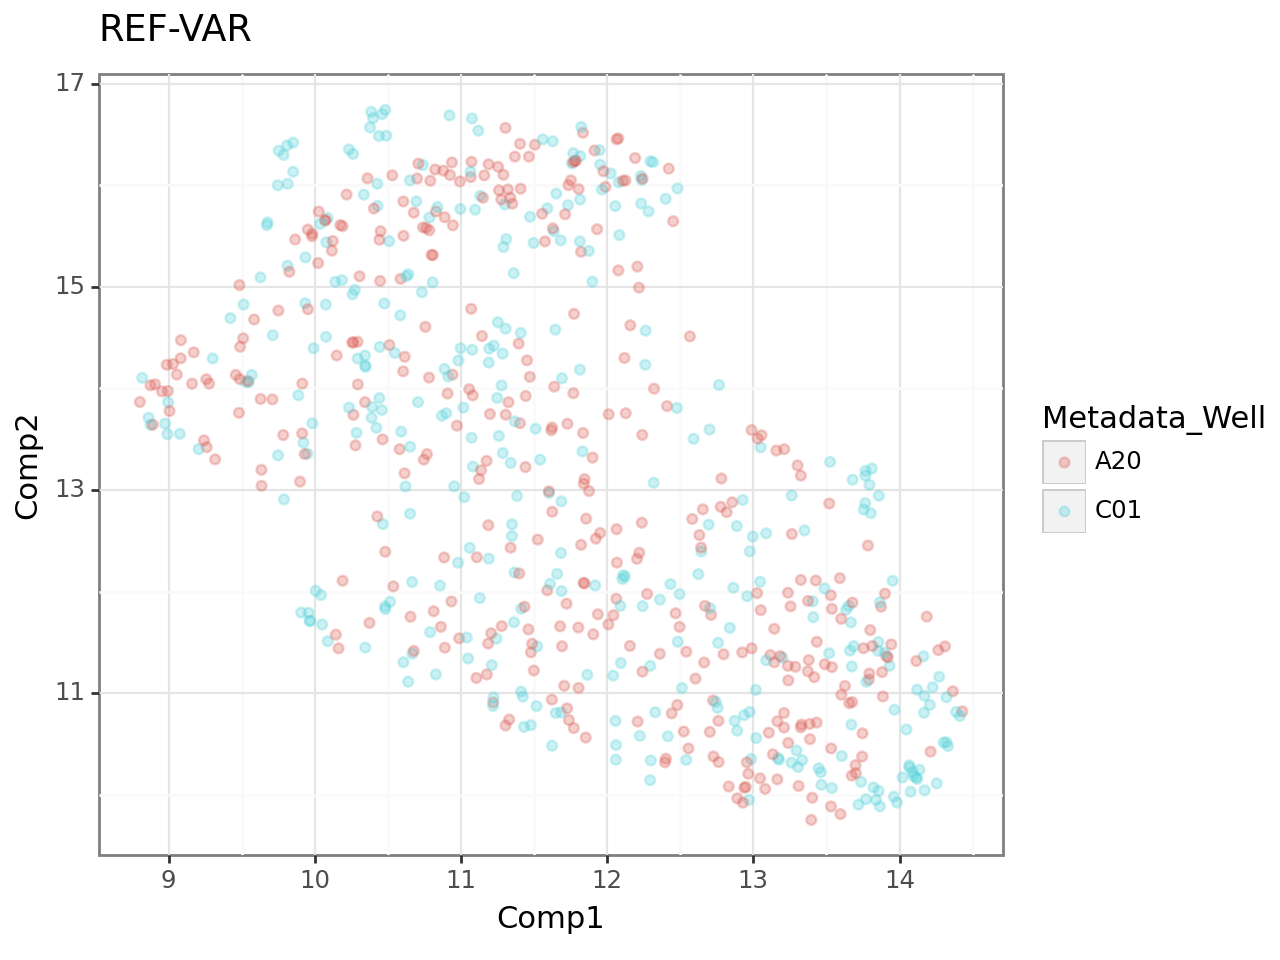

In [46]:
plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Well')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

Takeaways:

- In the case of all features and non-protein features, all pairs of wells were separable, but the difference was most pronounced for REF-VAR (yay!)
- The brightfield feature UMAP was not what I would have expected; the brightfield classifiers performed by far the best, and yet they show no separation in the UMAP
- The UMAPs seem very sensitive - the protein feature plots don't make much sense
- This analysis highlighted how unreliable UMAPs are :(

## All plates, protein features

In [5]:
# Compute UMAP
reducer = umap.UMAP(n_components=2)

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr.select(feat_cols_protein)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv.select(feat_cols_protein)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv.select(feat_cols_protein)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)s
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

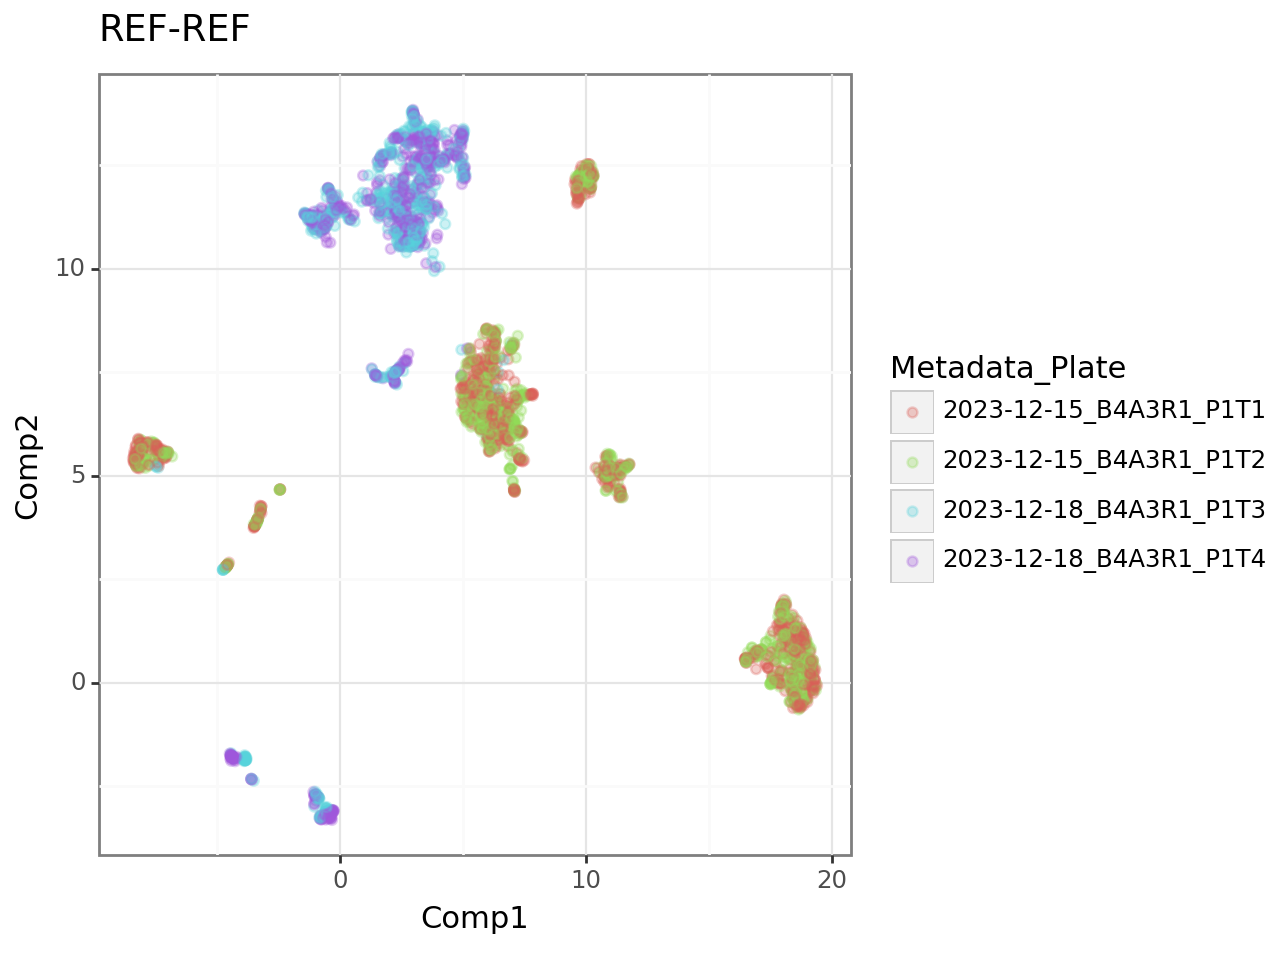

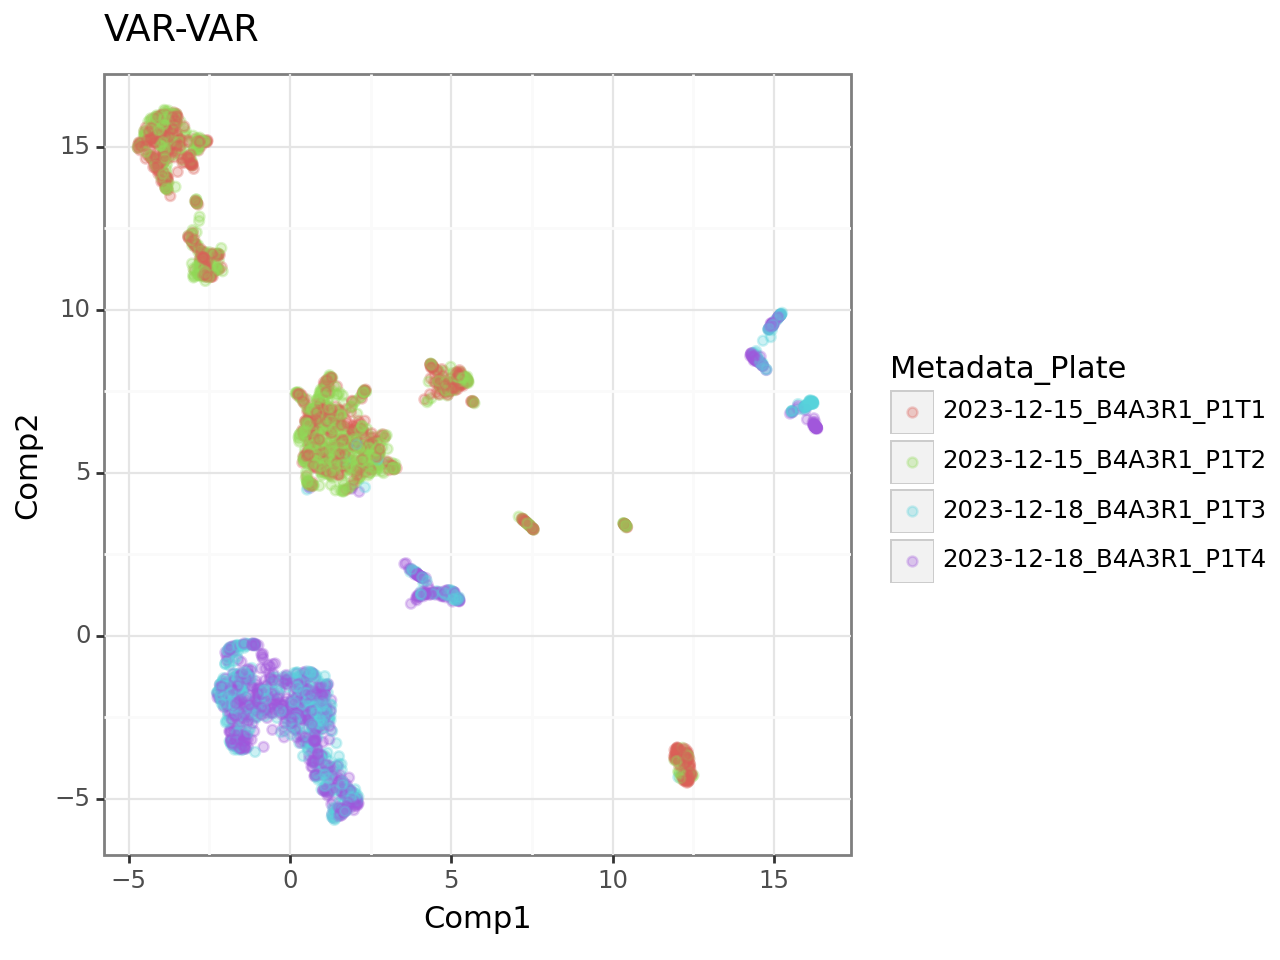

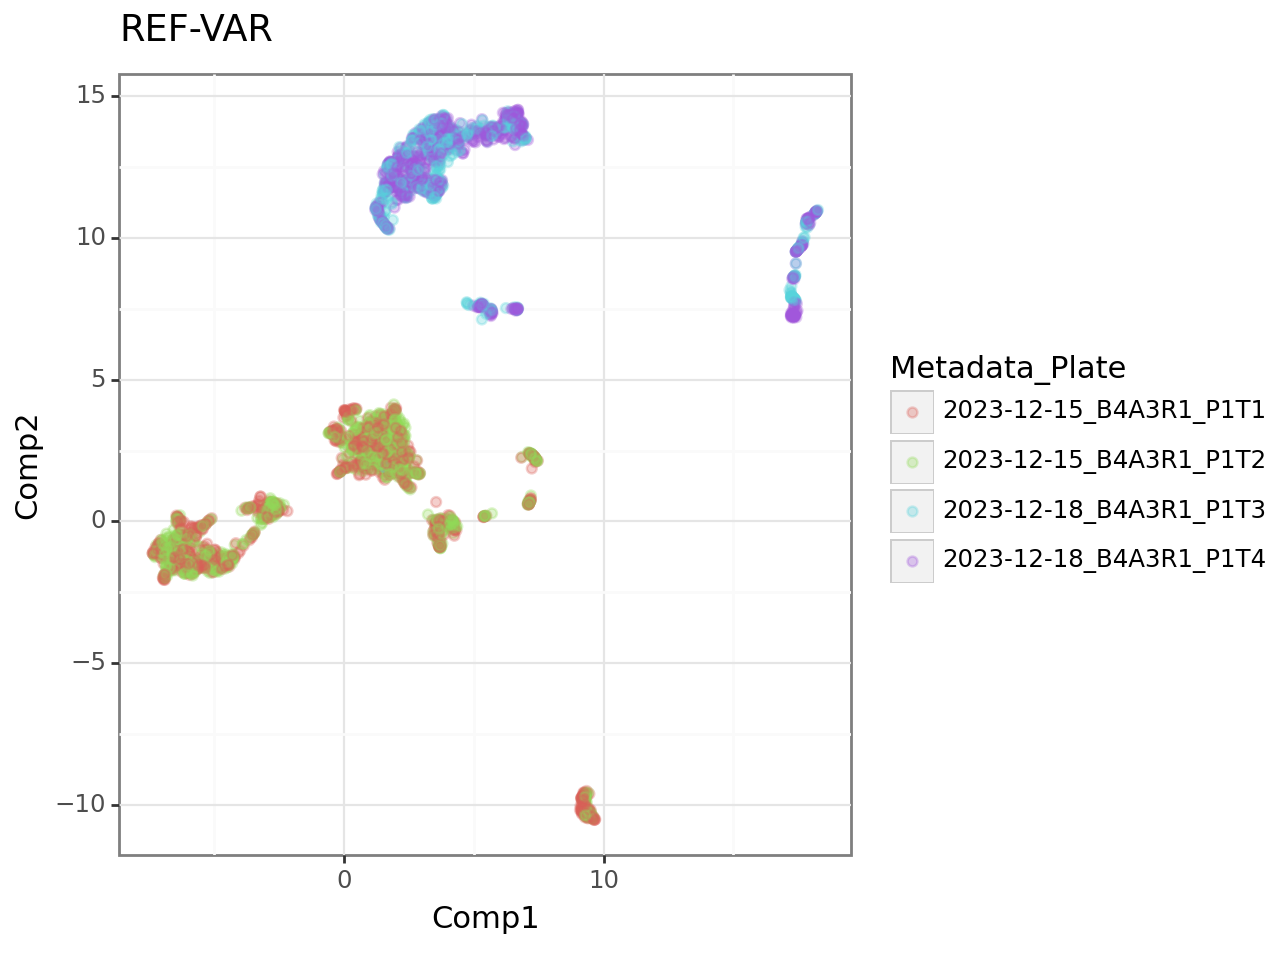

In [6]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_gradient

plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

## All plates, non-protein features

In [7]:
# Compute UMAP
reducer = umap.UMAP(n_components=2)

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr.select(feat_cols_non_protein)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv.select(feat_cols_non_protein)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv.select(feat_cols_non_protein)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

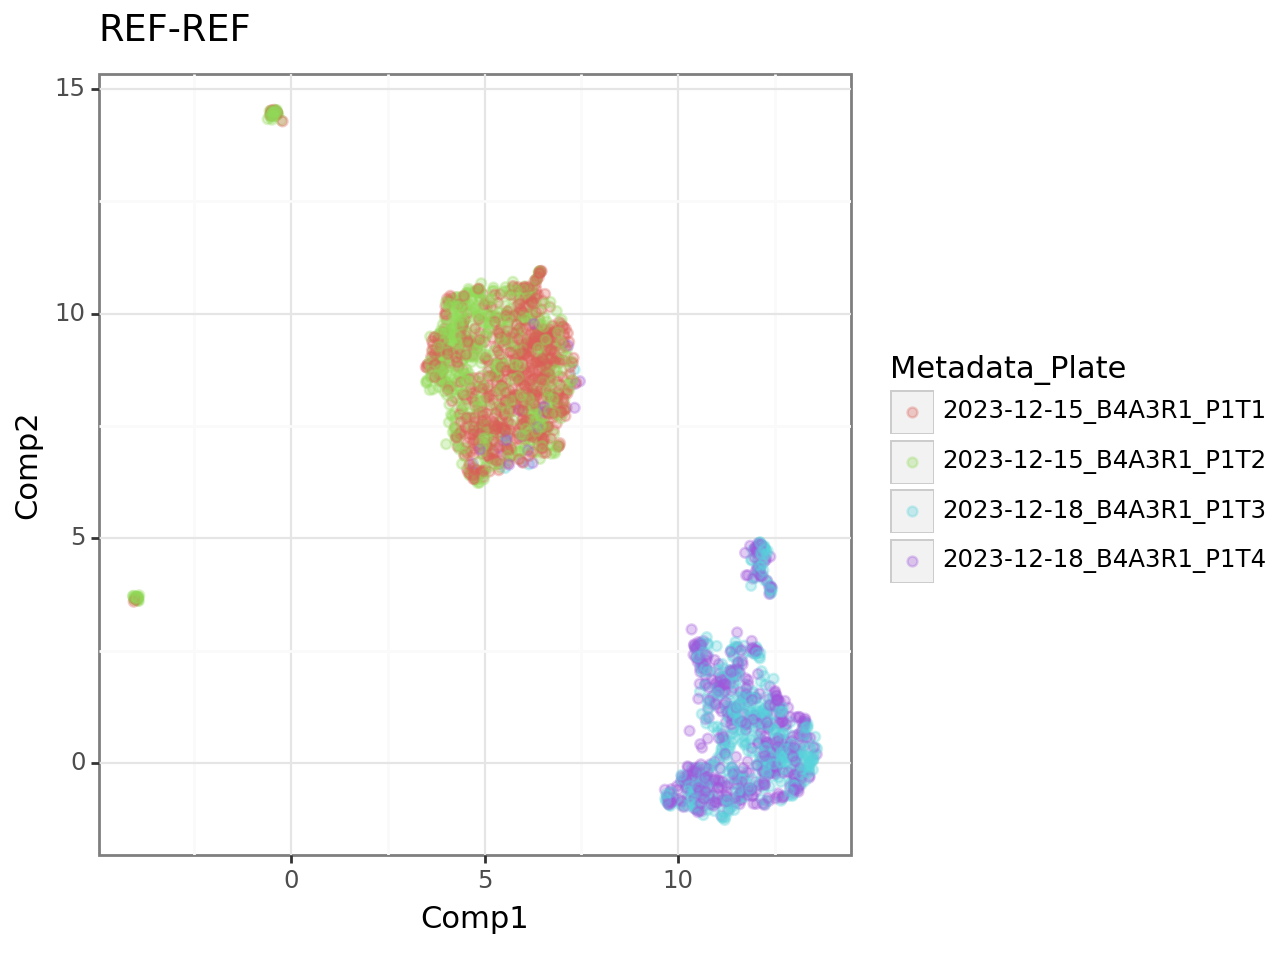

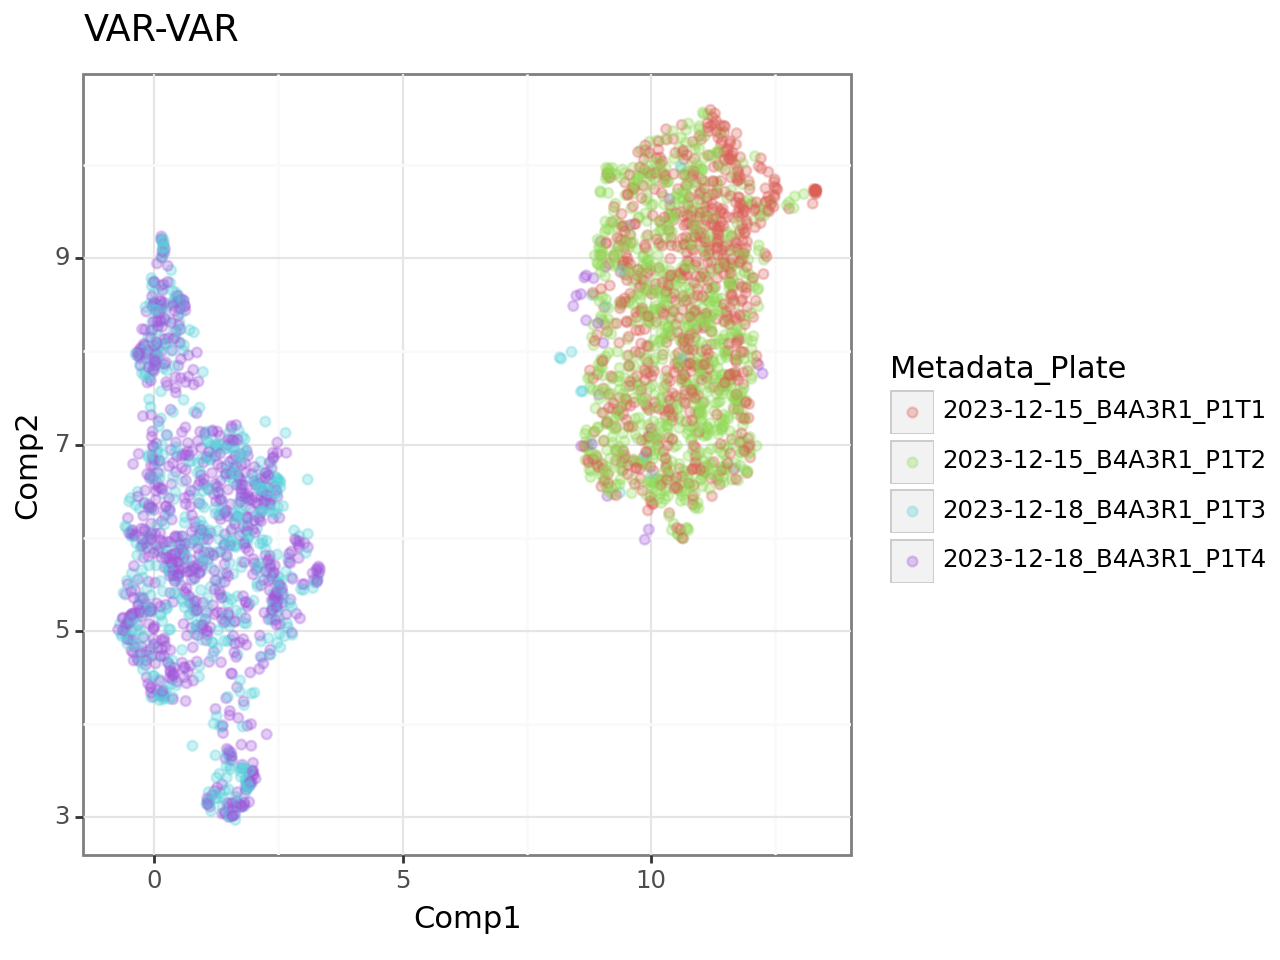

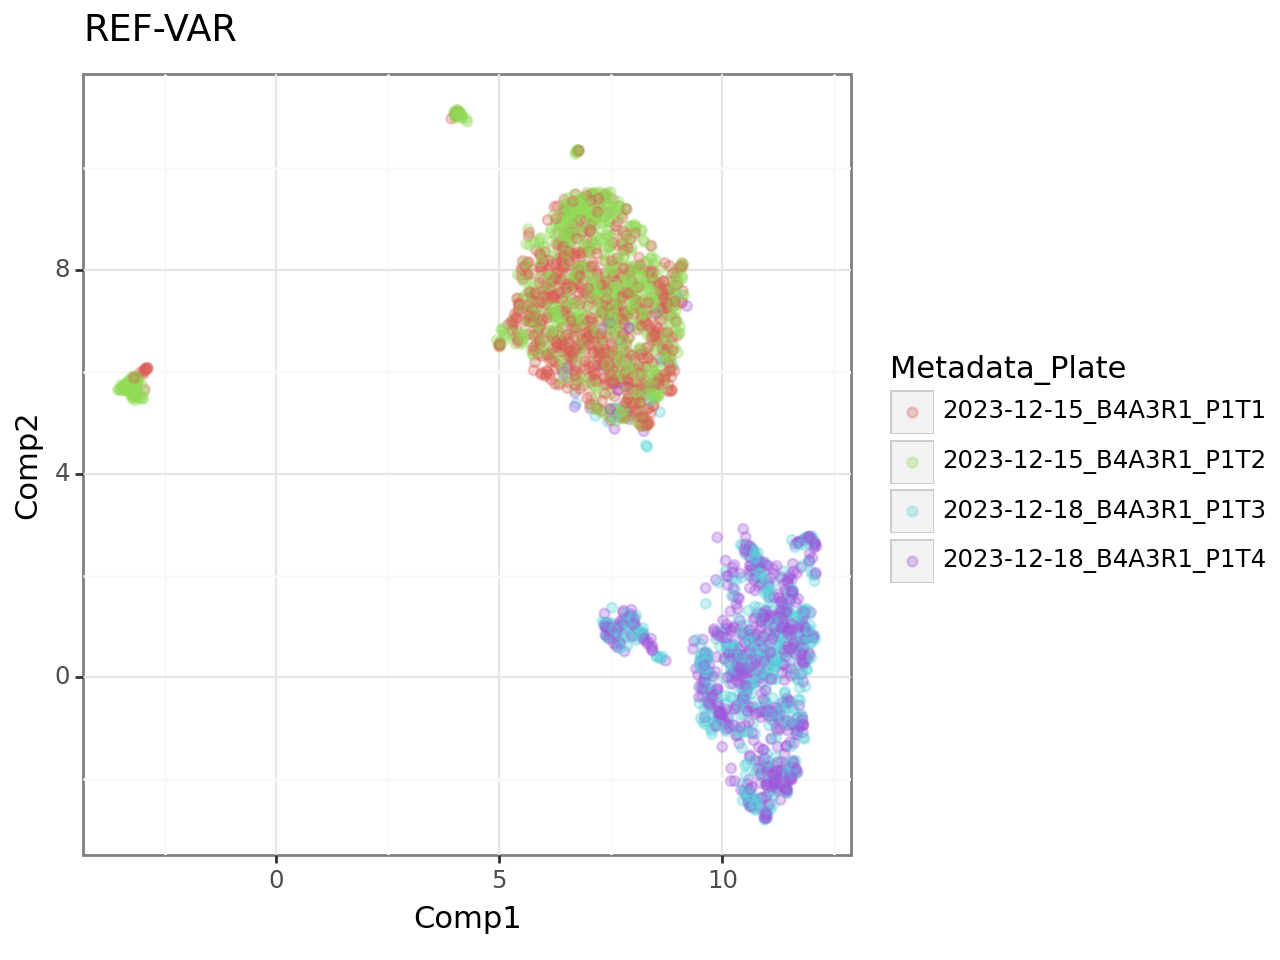

In [8]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_gradient

plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)

## All plates, brightfield features

In [9]:
# Compute UMAP
reducer = umap.UMAP(n_components=2)

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rr.select(feat_cols_brightfield)))
umap_rr = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rr = pl.concat([df_rr.select(meta_col), umap_rr], how = "horizontal")

# VAR-VAR
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_vv.select(feat_cols_brightfield)))
umap_vv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_vv = pl.concat([df_vv.select(meta_col), umap_vv], how = "horizontal")

# REF-REF
embedding = reducer.fit_transform(StandardScaler().fit_transform(df_rv.select(feat_cols_brightfield)))
umap_rv = pl.DataFrame(
    {
        "Comp1": embedding[:,0],
        "Comp2": embedding[:,1]
    }
)
umap_rv = pl.concat([df_rv.select(meta_col), umap_rv], how = "horizontal")

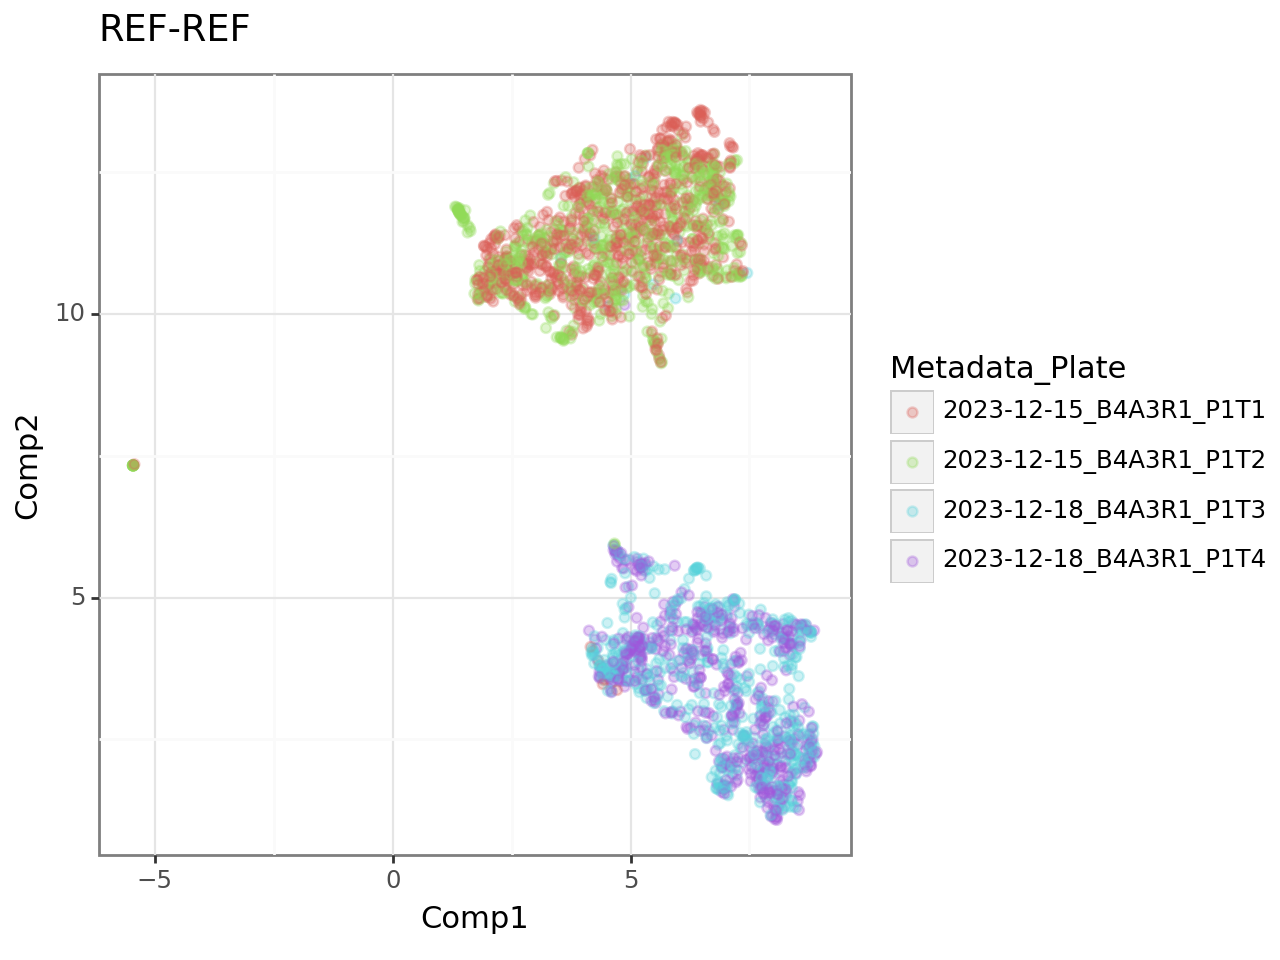

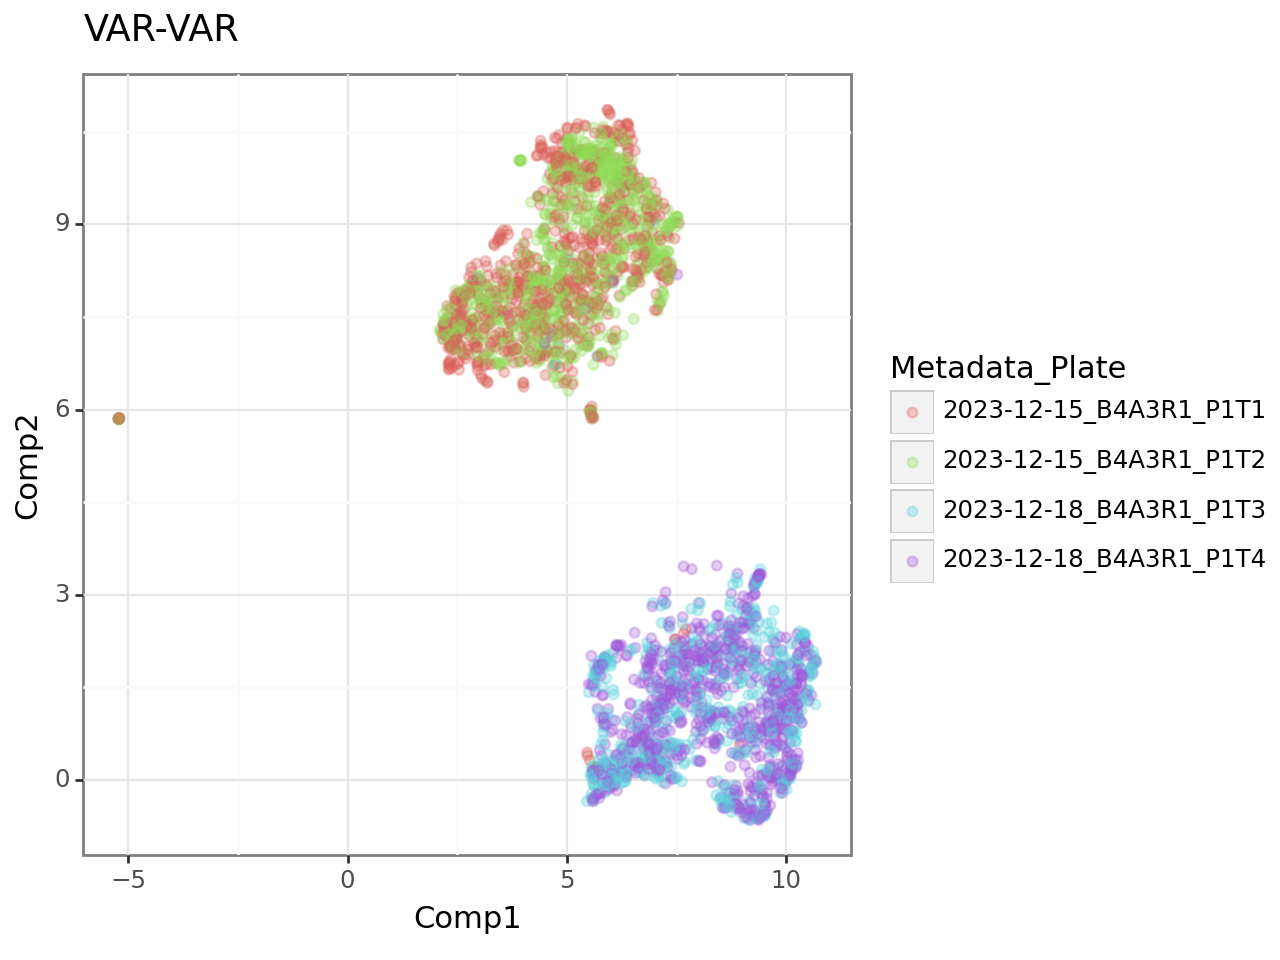

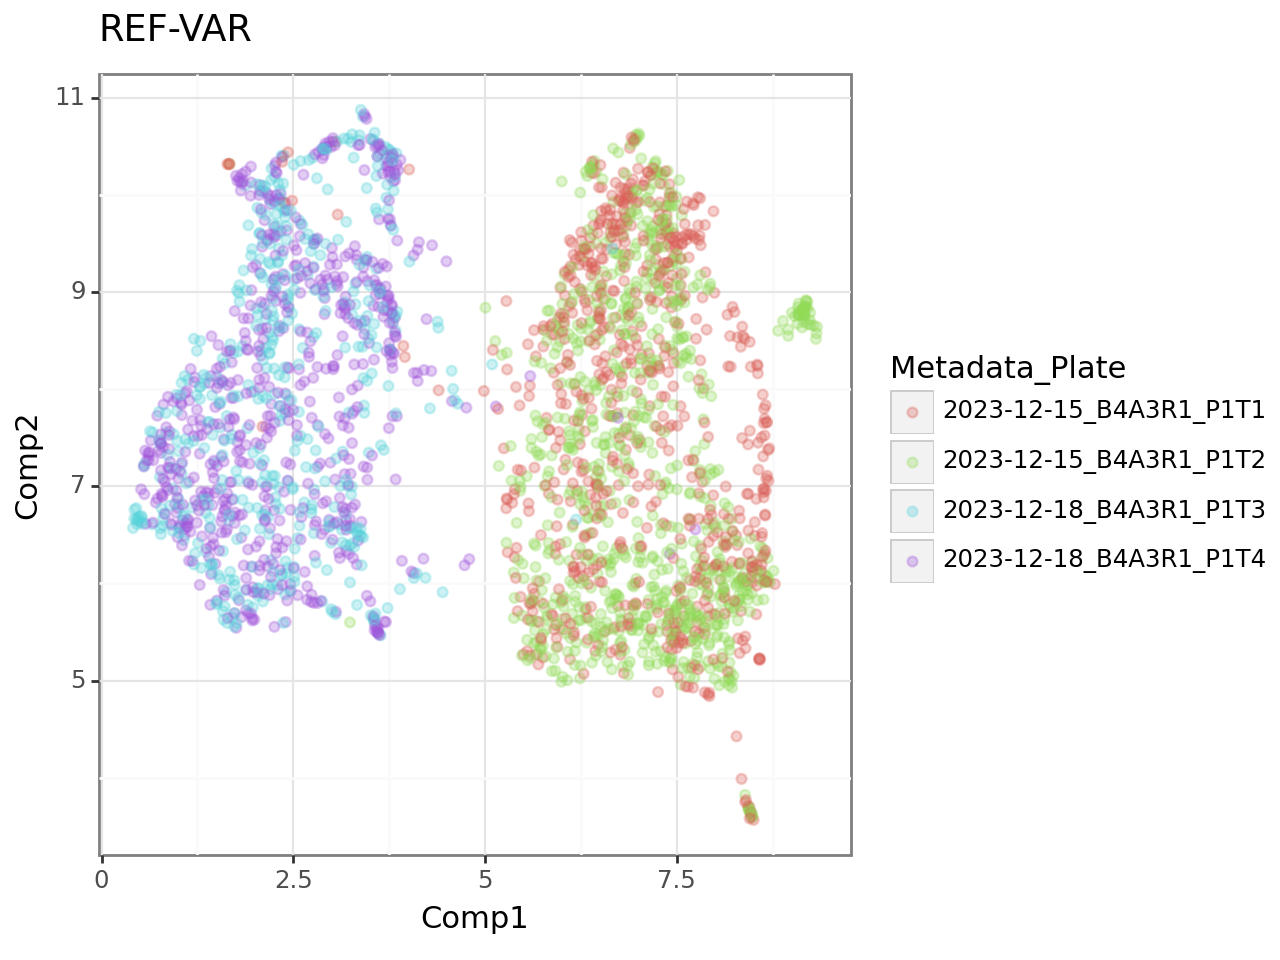

In [13]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_gradient

plot1 = (ggplot(umap_rr.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-REF"))
print(plot1)

plot2 = (ggplot(umap_vv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("VAR-VAR"))
print(plot2)

plot3 = (ggplot(umap_rv.sample(fraction=1.0, shuffle=True))
         + aes(x = "Comp1", y = "Comp2", color = 'Metadata_Plate')
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("REF-VAR"))
print(plot3)